In [1]:
import sys
import os
sys.path.append('../src')

In [6]:
import numpy as np
import pandas as pd
import pcalg
import networkx as nx
from conditional_independence import partial_correlation_suffstat, partial_correlation_test
from structure_learning.samplers import PartitionMCMC, StructureMCMC
from structure_learning.data import SyntheticDataset, Data
from structure_learning.data_structures import DAG
from structure_learning.proposals import PartitionProposal
from structure_learning.scores import BGeScore, BDeuScore

In [7]:
np.random.seed(32205)
data = np.zeros((200, 3))

data[:,0] = np.random.choice([1,2], size=200)
data[:,1] = np.random.choice([3,4], size=200)
data[:,2] = np.logical_and(data[:,0]==1, data[:,1]==3)
data = Data(pd.DataFrame(data, columns=['A', 'B', 'C']))
gt = DAG(np.array([[0,0,1],[0,0,1],[0,0,0]]), data.columns)

In [13]:
# M = StructureMCMC(max_iter=5000, data=data, score_object='bge', pc_init=False)
M = PartitionMCMC(max_iter=3000, data=data, score_object='bde', pc_init=False, result_type='distribution')

{0, 2}
{0, 1, 2}
None
Precomputed score tables


In [16]:
mcmc_results, acceptance = M.run()
print('Acceptance_ratio:', acceptance)

Acceptance_ratio: 1.1643333333333334


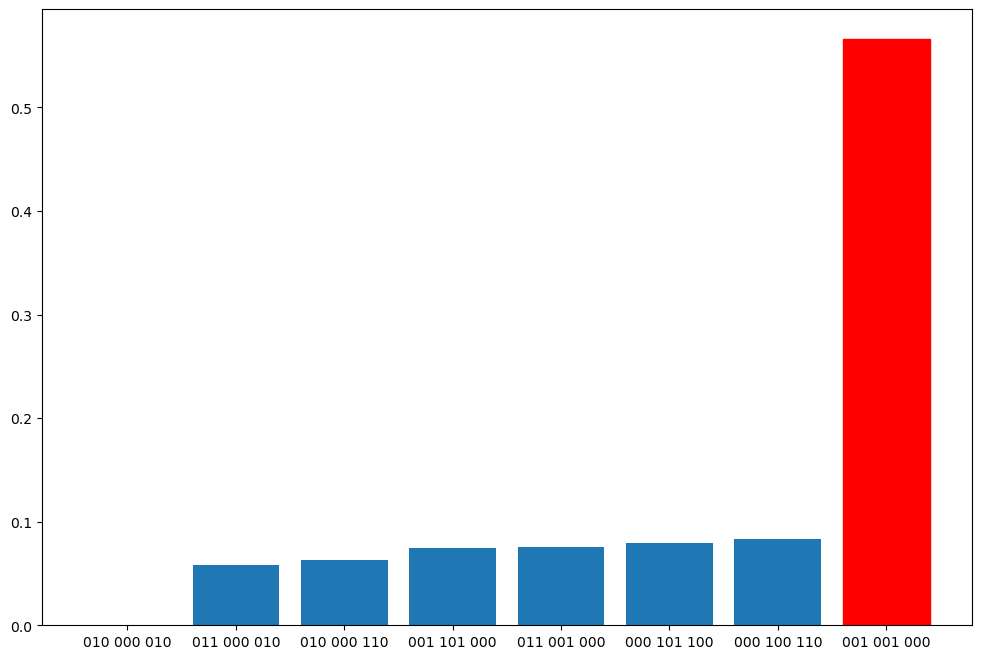

In [17]:
from matplotlib import pyplot as plt

key = gt.to_key()
plt.rcParams['figure.figsize'] = 12,8
bars, keys, counts = mcmc_results.plot(sort=True, normalise=True, limit=100)
bars[np.where(np.array(keys)==key)[0][0]].set_color('red')

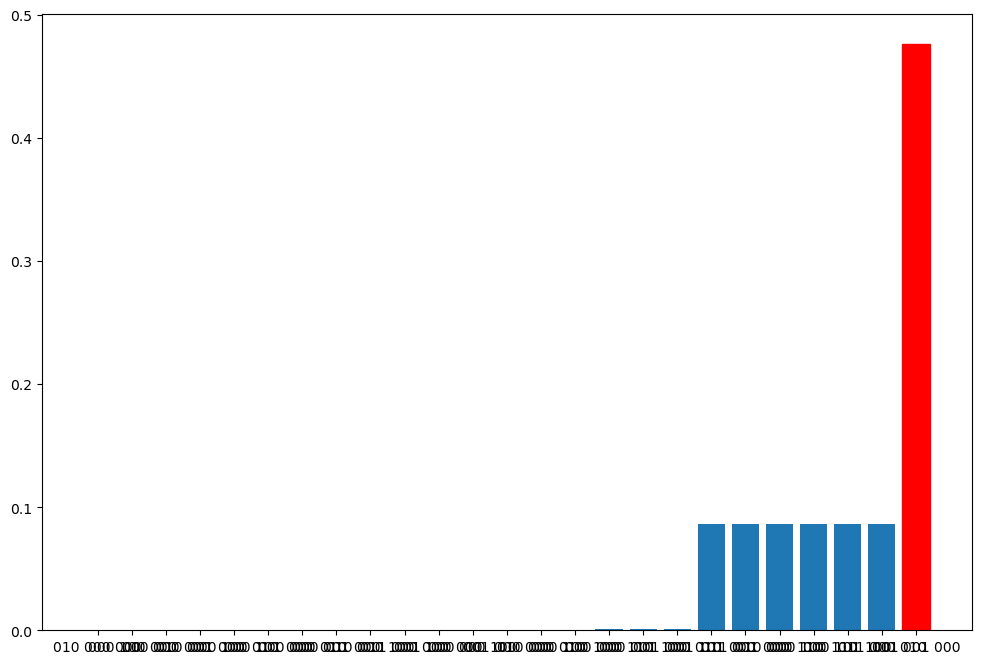

In [ ]:
from structure_learning.scores import BGeScore, BDeuScore
from structure_learning.distributions import Distribution

true_dist = Distribution.compute_distribution(data, score=BGeScore)
bars2, keys, counts = true_dist.plot(prop='p', sort=True, limit=100)
bars2[np.where(np.array(keys)==key)[0][0]].set_color('red')


In [25]:
from mcmc.evaluation.metrics import kl_divergence, jensen_shannon_divergence, mean_squared_error, mean_absolute_error
from mcmc.inference.posterior import generate_all_dags_keys, generate_all_dags

all_dags = generate_all_dags(data=data, my_score=BDeuScore)

Total 3 node DAGs generated = 25


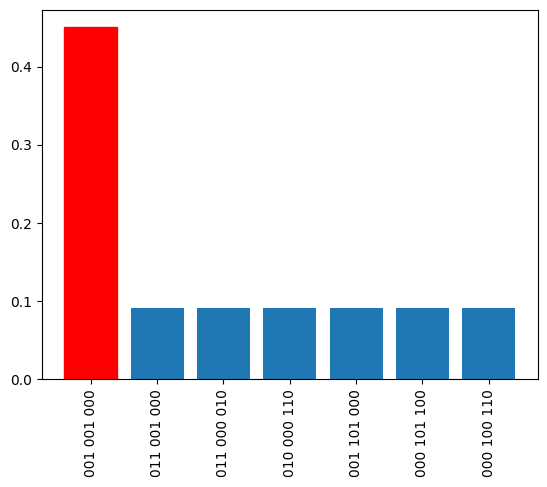

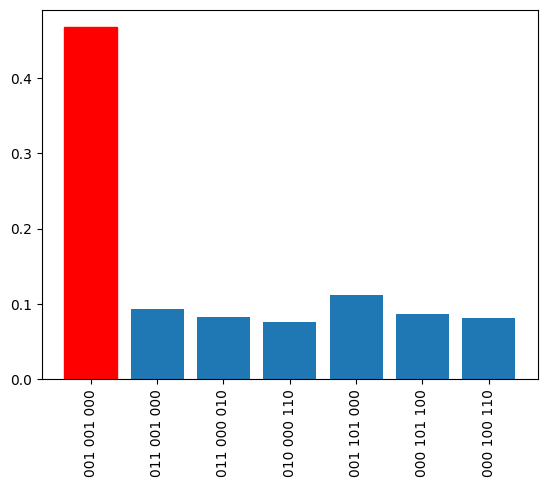

In [26]:

from mcmc.inference.posterior import compute_true_distribution

true_distribution = compute_true_distribution(all_dags)
dst = {key:count/sum(counts) for key, count in zip(keys, counts)}
approx_distribution = {key: (dst[key] if key in dst else 0) for key in true_distribution.keys()}

threshold = 1e-5
k = list(true_distribution.keys())
for _k in k:
    if true_distribution[_k] < threshold and approx_distribution[_k] < threshold:
        del true_distribution[_k]
        del approx_distribution[_k]
k = np.array(list(true_distribution.keys()))
bars = plt.bar(k, true_distribution.values())
# print(k, key)
bars[np.where(k==key)[0][0]].set_color('red')
plt.xticks(range(len(true_distribution.keys())), true_distribution.keys(), rotation=90);
plt.figure()
bars = plt.bar(approx_distribution.keys(), approx_distribution.values())
bars[np.where(k==key)[0][0]].set_color('red')
plt.xticks(range(len(approx_distribution.keys())), approx_distribution.keys(), rotation=90);

In [27]:
from mcmc.evaluation.metrics import mean_squared_error, mean_absolute_error, kl_divergence, jensen_shannon_divergence

print('KL div', kl_divergence(approx_distribution, true_distribution))
print('JS div', jensen_shannon_divergence(approx_distribution, true_distribution))
print('MSE', mean_squared_error(true_distribution, approx_distribution))
print('MAE', mean_absolute_error(true_distribution, approx_distribution))

KL div 0.004876516624931219
JS div 0.001216132155261214
MSE 0.00016143273272026696
MAE 0.010993710547995939
